# Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -r sample_data

In [3]:
!pip install timm

     |████████████████████████████████| 431 kB 14.2 MB/s 


In [4]:
# !pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 9.1 MB/s 
     |████████████████████████████████| 948 kB 19.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=6ba509306e2f650eb7db242621f01412e1d1d5991313a66fc0e8667a63dfdbb0
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Libraries

In [5]:
import torch
import timm
import pandas as pd
import os
import cv2
import numpy as np

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cpu')

# csv

In [6]:
PATH = "/content/drive/MyDrive/ISIC/2016"
os.listdir(PATH)

['ISBI2016_ISIC_Part3_Training_Data.zip',
 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Test_Data.zip',
 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Training_Data',
 'ISBI2016_ISIC_Part3_Test_Data']

In [7]:
train_path = f'{PATH}/ISBI2016_ISIC_Part3_Training_Data/'
test_path = f'{PATH}/ISBI2016_ISIC_Part3_Test_Data/'

train_csv = f'{PATH}/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
test_csv = f'{PATH}/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

header_list = ['image_name','benign_malignant']
train = pd.read_csv(train_csv, names=header_list, index_col=False)

header_list = ['image_name','target']
test = pd.read_csv(test_csv, names=header_list, index_col=False)

In [8]:
def to_int(label):
  if label == "benign":
    return 0.0
  elif label == "malignant":
    return 1.0

def to_path_train(image_name):
  return train_path +image_name+'.jpg'

def to_path_test(image_name):
  return test_path +image_name+'.jpg'
train['target'] = train.benign_malignant.apply(to_int)
train['path'] = train.image_name.apply(to_path_train)

test['path'] = test.image_name.apply(to_path_test)

In [9]:
import numpy as np
from sklearn import model_selection
FOLDS = 3
kf = model_selection.StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold_, (train_idx, test_idx) in enumerate(kf.split(X=train,y=train['target'])):
  train.loc[test_idx,'kfold'] = fold_

  train_fold = train.iloc[train_idx]
  val_fold = train.iloc[test_idx]
  train_fold.reset_index(drop=True, inplace=True)
  val_fold.reset_index(drop=True, inplace=True)
  train_fold.to_csv(f'./train_fold{FOLDS}.csv')
  val_fold.to_csv(f'./val_fold{FOLDS}.csv')
  print("Fold:",fold_+1)
  print(train_idx.shape, test_idx.shape)

Fold: 1
(600,) (300,)
Fold: 2
(600,) (300,)
Fold: 3
(600,) (300,)


# Dataset class

In [10]:
from torch.utils.data import Dataset
from skimage import io
from skimage.transform import resize

import cv2
class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      image = self.transform(image=image)["image"].astype(np.float32)
    else:
      image = image.astype(np.float32)/ 255.0
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  # def __getitem__(self, ix):
  #   img = io.imread(self.images[ix])
  #   img = resize(img,(224,224))
  #   image = torch.from_numpy(img).float()
  #   if self.transform is not None:
  #     image = self.transform(image=image)["image"].astype(np.float32)
  #   else:
  #     img = img.transpose(2, 0, 1)
  #   if self.train:
  #     target = torch.tensor([self.labels[ix]]).float()
  #     return image, target
  #   return image
        
  def __len__(self) -> int:
    return len(self.images)

# Data Loader

In [12]:
from torch.utils.data import DataLoader
dataset = {
    'train': MelanomaDataset(train_fold['path'], train_fold['target']),
    'val': MelanomaDataset(val_fold['path'], val_fold['target'])
}

In [13]:
BATCH=32
train_loader = DataLoader(dataset['train'], batch_size=BATCH, shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=BATCH)

## print raw datasets

In [126]:
dataset['train'][0][1]

tensor([1.])

In [70]:
print(dataset['train'][0][0].shape)
dataset['train'][0][0]

torch.Size([3, 224, 224])


tensor([[[0.0549, 0.0275, 0.0118,  ..., 0.0118, 0.0078, 0.0275],
         [0.0314, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0000],
         [0.0275, 0.0314, 0.0196,  ..., 0.0196, 0.0235, 0.0196],
         ...,
         [0.0471, 0.0431, 0.0431,  ..., 0.0941, 0.0863, 0.0745],
         [0.0353, 0.0667, 0.0314,  ..., 0.0902, 0.0745, 0.0510],
         [0.0314, 0.0235, 0.0392,  ..., 0.0863, 0.0627, 0.0667]],

        [[0.0549, 0.0275, 0.0118,  ..., 0.0118, 0.0078, 0.0275],
         [0.0314, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0000],
         [0.0275, 0.0314, 0.0196,  ..., 0.0196, 0.0235, 0.0196],
         ...,
         [0.0471, 0.0431, 0.0431,  ..., 0.1529, 0.1176, 0.0824],
         [0.0353, 0.0667, 0.0314,  ..., 0.1294, 0.0941, 0.0667],
         [0.0314, 0.0235, 0.0392,  ..., 0.1137, 0.0902, 0.0902]],

        [[0.0549, 0.0275, 0.0118,  ..., 0.0118, 0.0078, 0.0275],
         [0.0314, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0000],
         [0.0275, 0.0314, 0.0196,  ..., 0.0196, 0.0235, 0.

In [179]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1]))

# Show batch

In [129]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

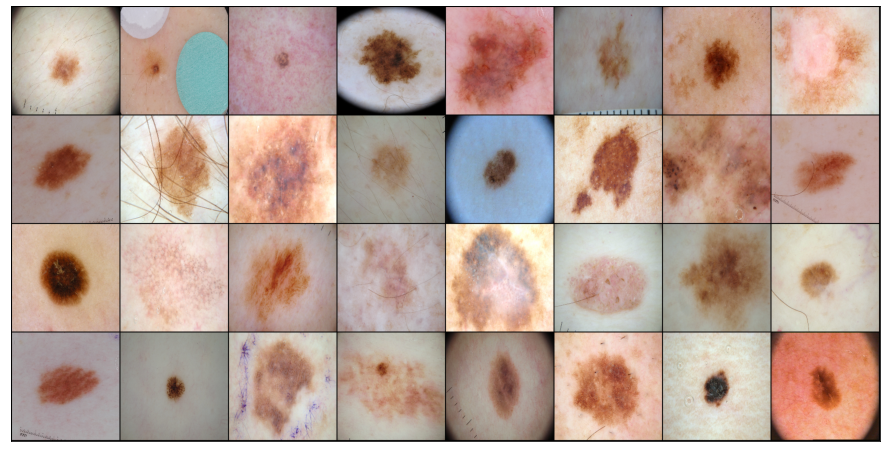

In [130]:
show_batch(train_loader)

# Generate mean and std from dataset
mean: (0.72196096, 0.6170128, 0.56728417) \\
std: (0.16372901, 0.17203921, 0.19337493)

In [11]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      # Mean over batch, height and width, but not over the channels
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [59]:
mean, std = get_mean_and_std(DataLoader(dataset['train']))
print(mean)
print(std)

(0.72196096, 0.6170128, 0.56728417)
(0.16372901, 0.17203921, 0.19337493)


## compute_img_mean_std function (not used)

In [57]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    print(f'mean {means}')
    print(f'std {stds}')
    return means, stds

In [58]:
compute_img_mean_std(train['path'])

100%|██████████| 900/900 [06:40<00:00,  2.25it/s]


(224, 224, 3, 900)
mean [0.64762354, 0.64762354, 0.64762354]
std [0.19479683, 0.19479683, 0.19479683]


([0.64762354, 0.64762354, 0.64762354], [0.19479683, 0.19479683, 0.19479683])

# Augmentation

In [63]:
import albumentations as A

train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean, std)
    ]
)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean, std)
    ]
)

dataset_aug = {
    'train': MelanomaDataset(train_fold['path'], train_fold['target'],transform=train_transform),
    'val': MelanomaDataset(val_fold['path'], val_fold['target'],transform=val_transform)
}

## Visualize augmentation

In [71]:
import random
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image/255.)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

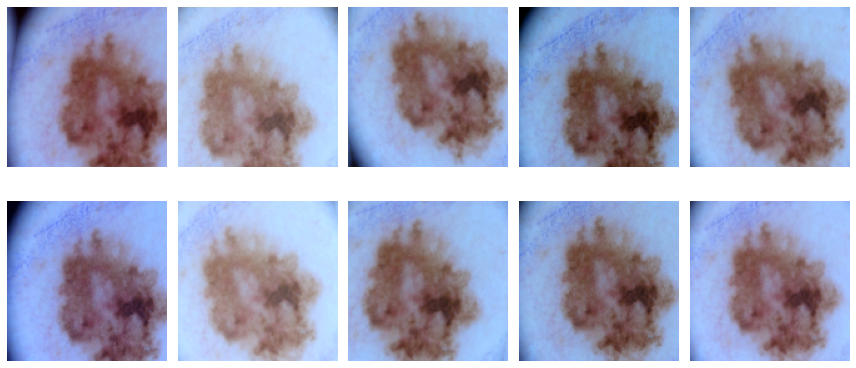

In [74]:
import matplotlib.pyplot as plt
random.seed(42)
visualize_augmentations(dataset_aug['train'])

# Model

In [132]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, n_class)
        # self.model.fc = nn.Linear(in_features=net.fc.in_features, out_features=2, bias=True)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

In [133]:
model = MelanomaClassifier('resnet101',1,True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet101_a1h-36d3f2aa.pth" to /root/.cache/torch/hub/checkpoints/resnet101_a1h-36d3f2aa.pth
